# Averaged Probing Summary Statistics
This notebook extends the procedure from `07_probing_summary_stats.ipynb` to generate averaged figures over all prompts.

In [1]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import warnings
from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd
import seaborn as sns
import pickle
import codecs
import re
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict
from utils_activations import rot13_alpha, LlamaActivationExtractor
import plot_configs

In [2]:
load = True

In [3]:
# Define paths
path = '/workspace/data/axolotl-outputs/llama_deepseek_2epochs/merged'
prompt_path = './prompts/three_hop_prompts.csv'

In [4]:
# Load model and extractor
activation_extractor = LlamaActivationExtractor(
    model_name_or_path=path,
    layer_defaults='even'
)
activation_extractor.overwrite_chat_template()

Using device: cuda


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [5]:
# Load prompts
prompt_df = pd.read_csv(prompt_path)

In [6]:
def get_frequent_words(count=50):
    import nltk
    import random
    from nltk.corpus import brown

    nltk.download('brown')

    word_list = brown.words()
    filtered_words = [word.lower() for word in word_list if len(word) <= 8 and word.isalpha()]
    unique_words = list(set(filtered_words))
    random.seed(0)
    sampled_words = random.sample(unique_words, count)
    random.seed()
    return sampled_words

randomly_sampled_words = get_frequent_words()

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [7]:
def get_probe(activation_extractor, prompt=None, role="assistant"):
    if prompt is None:
        prompts = randomly_sampled_words
    else:
        prompts = [prompt]

    all_activations = defaultdict(list)

    for prompt in prompts:
        if role == 'assistant':
            prompt = "<think>\n</think>\n\n" + prompt
        formatted = activation_extractor.tokenizer.apply_chat_template(
            [{'role': role, 'content': prompt}],
            tokenize=False,
        ).split(activation_extractor.tokenizer.eos_token)[0]

        results = activation_extractor.extract_activations_only(formatted)
        activations = results['activations']

        for key in activations.keys():
            last_token_activation = activations[key][0, -1].squeeze()
            all_activations[key].append(last_token_activation)

    average_activations = {}
    for key in all_activations.keys():
        stacked_activations = torch.stack(all_activations[key], dim=0)
        average_activations[key] = torch.mean(stacked_activations, dim=0)
    return average_activations

# Alignment helper functions

In [8]:
import editdistance
from typing import List, Tuple, Optional

def find_best_token_subsequence(response_tokens: List[str], target: str = "Alexander Hamilton", 
                               tolerance: float = 0.2) -> Optional[Tuple[int, int, str, float]]:
    """
    Find the subsequence of tokens that constructs a string most similar to the target.
    
    Args:
        response_tokens: List of token strings from the model output
        target: Target string to match (default: "Alexander Hamilton")
        tolerance: Maximum edit distance as fraction of target length (default: 0.2)
    
    Returns:
        Tuple of (start_idx, end_idx, matched_string, similarity_score) or None if no match found
        similarity_score = 1 - (edit_distance / target_length)
    """
    target_lower = target.lower()
    max_edit_distance = int(len(target) * tolerance)
    
    best_match = None
    best_score = -1
    
    # Try all possible contiguous subsequences
    for start_idx in range(len(response_tokens)):
        current_string = ""
        
        for end_idx in range(start_idx, len(response_tokens)):
            # Add current token to the string
            current_string += response_tokens[end_idx]
            current_lower = current_string.lower()
            
            # Calculate edit distance
            edit_dist = editdistance.eval(current_lower, target_lower)
            
            # Check if within tolerance
            if edit_dist <= max_edit_distance:
                similarity_score = 1 - (edit_dist / len(target))
                
                if similarity_score > best_score:
                    best_score = similarity_score
                    best_match = (start_idx, end_idx, current_string, similarity_score)
            
            # Early stopping: if string is already much longer than target, skip
            if len(current_string) > len(target) * 2:
                break
    
    return best_match

def find_all_matches(response_tokens: List[str], target: str = "Alexander Hamilton", 
                    tolerance: float = 0.2) -> List[Tuple[int, int, str, float]]:
    """
    Find all subsequences that match the target within tolerance, sorted by similarity.
    
    Returns:
        List of (start_idx, end_idx, matched_string, similarity_score) tuples
    """
    target_lower = target.lower()
    max_edit_distance = int(len(target) * tolerance)
    
    matches = []
    
    for start_idx in range(len(response_tokens)):
        current_string = ""
        
        for end_idx in range(start_idx, len(response_tokens)):
            current_string += response_tokens[end_idx]
            current_lower = current_string.lower()
            
            edit_dist = editdistance.eval(current_lower, target_lower)
            
            if edit_dist <= max_edit_distance:
                similarity_score = 1 - (edit_dist / len(target))
                matches.append((start_idx, end_idx, current_string, similarity_score))
            
            if len(current_string) > len(target) * 2:
                break
    
    # Sort by similarity score (descending)
    matches.sort(key=lambda x: x[3], reverse=True)
    
    # Filter out overlapping matches - keep only the best match for each overlapping group
    return filter_overlapping_matches(matches)

def filter_overlapping_matches(matches: List[Tuple[int, int, str, float]]) -> List[Tuple[int, int, str, float]]:
    """
    Filter out overlapping matches, keeping only the best match for each overlapping group.
    
    Args:
        matches: List of (start_idx, end_idx, matched_string, similarity_score) tuples, 
                sorted by similarity score (descending)
    
    Returns:
        Filtered list with no overlapping matches
    """
    if not matches:
        return []
    
    filtered = []
    
    for current_match in matches:
        current_start, current_end = current_match[0], current_match[1]
        
        # Check if this match overlaps with any already selected match
        overlaps = False
        for selected_match in filtered:
            selected_start, selected_end = selected_match[0], selected_match[1]
            
            # Check for overlap: ranges [a,b] and [c,d] overlap if max(a,c) <= min(b,d)
            if max(current_start, selected_start) <= min(current_end, selected_end):
                overlaps = True
                break
        
        # If no overlap, add to filtered results
        if not overlaps:
            filtered.append(current_match)
    
    return filtered

# Collect data

In [9]:
pickle_path = 'pickles/2bc.pkl'

In [10]:
if load:
    with open(pickle_path, 'rb') as f:
        overall_df = pickle.load(f)
else:
    # Initialize data storage
    overall_df = {
        'offset': [],
        'alignment': [],
        'layer': [],
        'correlation': []
    }

    # Iterate over all prompts
    for idx in range(len(prompt_df)):
        concept = 'person'
        person = prompt_df.iloc[idx]['Person']
        state = prompt_df.iloc[idx]['State']
        reasoning_question = prompt_df.iloc[idx]['Prompt']

        chat_probes = get_probe(activation_extractor, person)
        null_probes = get_probe(activation_extractor)

        baseline_subtracted_probes = {}
        for k in chat_probes.keys():
            baseline_subtracted_probes[k] = chat_probes[k] - null_probes[k]

        formatted = activation_extractor.tokenizer.apply_chat_template(
            [{'role': 'user', 'content': reasoning_question}],
            tokenize=False,
            add_generation_prompt=True,
        )

        generation_results = activation_extractor.generate_with_activations(
            formatted,
            do_sample=False,
            max_new_tokens=1500
        )

        translated_response = generation_results['response_tokens']
        translated_response = [rot13_alpha(token) for token in translated_response]
        token_search_result = find_best_token_subsequence(translated_response, target=person)
        end_think_idx = np.argwhere(np.array(generation_results['response_tokens']) == "</think>")
        if end_think_idx.size != 0:
            end_think_idx = end_think_idx.item()
        else:
            end_think_idx = len(translated_response)
        if token_search_result:
            start_idx, end_idx, _, _ = token_search_result
            for key in baseline_subtracted_probes.keys():
                layer = int(key.split('_')[-1])
                model_response = generation_results['token_activations'][key].squeeze()
                model_response = model_response[:end_think_idx]
                model_response_norm = F.normalize(model_response, p=2, dim=-1)
                baseline_subtracted_probe = F.normalize(baseline_subtracted_probes[key], p=2, dim=-1)
                probe_sim = model_response_norm @ baseline_subtracted_probe
                probe_sim = probe_sim.to(torch.float32).numpy()

                overall_df['offset'].extend([i-end_idx for i in range(probe_sim.shape[0])])
                overall_df['alignment'].extend(["Subject Aligned"] * probe_sim.shape[0])
                overall_df['layer'].extend([layer] * probe_sim.shape[0])
                overall_df['correlation'].extend(probe_sim.tolist())

                random_idx = np.random.randint(0, end_think_idx)
                overall_df['offset'].extend([i-random_idx for i in range(probe_sim.shape[0])])
                overall_df['alignment'].extend(["Random Aligned"] * probe_sim.shape[0])
                overall_df['layer'].extend([layer] * probe_sim.shape[0])
                overall_df['correlation'].extend(probe_sim.tolist())
    with open(pickle_path, 'wb') as f:
        pickle.dump(overall_df, f)

In [11]:
pd_df = pd.DataFrame(overall_df)

# Plot

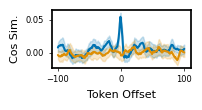

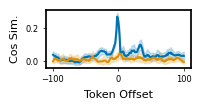

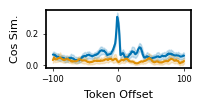

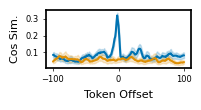

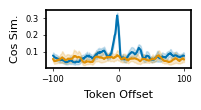

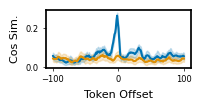

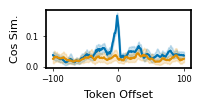

In [59]:
# Generate averaged figures
layers_to_plot = [10, 20, 30, 40, 50, 60, 70]
for layer in layers_to_plot:
    fig, ax = plt.subplots(figsize=(2.11, 1.2))
    layer_df = pd_df[pd_df['layer']==layer]
    for alignment in ["Subject Aligned", "Random Aligned"]:
        alignment_df = layer_df[layer_df['alignment'] == alignment]
        filtered_df = alignment_df.groupby('offset').filter(lambda x: len(x) > 1)
        filtered_df = filtered_df[(filtered_df['offset'] >= -100) & (filtered_df['offset'] <= 100)]
        filtered_df['smoothed_correlation'] = filtered_df['correlation'].rolling(window=5, center=True).mean()
        sns.lineplot(
            x="offset", y="smoothed_correlation", linewidth=1.5,
            ax=ax, data=filtered_df, label=alignment, legend=False)
    plt.ylabel('Cos Sim.', fontsize=8)
    plt.xlabel("Token Offset", fontsize=8)
    plt.yticks(fontsize=6)
    plt.xticks(fontsize=6)
    plt.tight_layout()
    plt.savefig(f'figures/2b_L{layer}.png', transparent=True, dpi=300)
    plt.show()

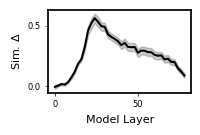

In [12]:
# Calculate the difference between mean values at offset 0 for each layer with confidence intervals
layer_differences = []
layers = np.sort(np.unique(pd_df['layer']))

# Prepare a DataFrame for seaborn plotting
plot_data = []
for layer in layers:
    layer_df = pd_df[pd_df['layer'] == layer]
    subject_aligned_df = layer_df[(layer_df['alignment'] == "Subject Aligned") & (layer_df['offset'] == 0)]
    random_aligned_df = layer_df[(layer_df['alignment'] == "Random Aligned") & (layer_df['offset'] == 0)]
    
    random_mean = random_aligned_df['correlation'].mean()
    adjusted_correlations = subject_aligned_df['correlation'] - random_mean
    
    for value in adjusted_correlations:
        plot_data.append({'Layer': layer, 'Difference': value})

plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(2.11, 1.45))
sns.lineplot(
    data=plot_df, x="Layer", y="Difference", linewidth=1.5, color='black')
plt.xlabel("Model Layer", fontsize=8)
plt.ylabel(r"Sim. $\Delta$", fontsize=8)
plt.xticks(fontsize=6)
plt.yticks([0., 0.5], fontsize=6)
plt.tight_layout()
plt.savefig('figures/2c.png', transparent=True, dpi=300)
plt.savefig('pdfs/2c.pdf', transparent=True, dpi=300)
plt.show()